In [17]:
# Importación de librerías
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Carga de datos
df=pd.read_csv("https://raw.githubusercontent.com/JersonGB22/DataScience_IBM_StockPredictionLSTM_Project/main/DataStorage/datasets_company_etl.csv")
df["Date"]=pd.to_datetime(df.Date)
df

,Date,Open,High,Low,Close,Adj Close,Volume,id_company
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791185,560518000,AAPL
1,2013-01-02,27.250000,27.730000,27.150000,27.620001,22.620338,52899300,MSFT
2,2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000,TSLA
3,2013-01-02,12.804000,12.905000,12.663000,12.865500,12.865500,65420000,AMZN
4,2013-01-02,17.918339,18.107130,17.846855,18.013729,18.013729,102033017,GOOG
...,...,...,...,...,...,...,...,...
27379,2023-09-18,298.190002,303.600006,297.799988,302.549988,302.549988,14234200,META
27380,2023-09-18,327.799988,330.399994,326.359985,329.059998,329.059998,16834200,MSFT
27381,2023-09-18,140.479996,141.750000,139.220001,139.979996,139.979996,42823500,AMZN
27382,2023-09-18,271.160004,271.440002,263.760010,265.279999,265.279999,101543300,TSLA


#### **Feature Engineering**

Esta etapa engloba varios procesos esenciales para preparar los datos antes de construir el modelo LSTM de predicción de las acciones máximas de las 7 empresas para los próximos 7 días. Los pasos clave son los siguientes:

1. **Selección de Variables**: Se seleccionan cuidadosamente las variables que se utilizarán en el modelo, basándose en el EDA previo.

2. **Escalamiento de Datos**: Cada variable en el conjunto de datos se escala individualmente utilizando la técnica MinMaxScaler. Esto garantiza que todas las variables tengan un rango común de [0;1] y facilita el proceso de entrenamiento del modelo.

3. **División de Datos Temporal**: La partición de datos se realiza de manera temporal, teniendo en cuenta la naturaleza de series de tiempo. Se utiliza el período desde el 2 de enero de 2013 hasta el 31 de diciembre de 2021 para el conjunto de entrenamiento, y desde el 1 de enero de 2022 hasta la fecha actual, el 18 de septiembre de 2023, para el conjunto de prueba. Esta división se hace para evitar la pérdida de periodicidad en los datos.

4. **Creación de Conjuntos de Datos de Entrada y Salida**: Se generan los conjuntos de entrenamiento y prueba que servirán como entrada y salida para el modelo LSTM. El conjunto de entrada tendrá dimensiones de la forma `(Número de datos, Bloques de 60 días consecutivos, Número de características)`, mientras que el conjunto de salida tendrá dimensiones de `(Número de predicciones, 7 días de predicciones consecutivas, Número de características (1=High))`.

En cada uno de estos pasos, se implementarán funciones específicas para garantizar una ejecución eficiente y reproducible de este proceso para cada una de las 7 empresas.

**OBSERVACIÓN:** Todas estas funciones se aplicarán a cada modelo de red LSTM en las etapas posteriores de este proyecto. Dado que estamos trabajando con 7 empresas diferentes, se crearán 7 notebooks. En esta fase de Feature Engineering, se presentará los resultados y análisis de cada función utilizando una empresa en particular como ejemplo ilustrativo.

In [22]:
# Función para la selección de variables
def variable_selection(df, company):
  df2=df.copy()
  df2=df2[df2.id_company==company]
  df2=df2.iloc[:, :5].reset_index(drop=True)

  return df2

In [23]:
# Se tomará como ejemplo la empresa Apple; para las demás empresas es exactamente lo mismo
df1=variable_selection(df, "AAPL")
df1

,Date,Open,High,Low,Close
0,2013-01-02,19.779285,19.821428,19.343929,19.608213
1,2013-01-03,19.567142,19.631071,19.321428,19.360714
2,2013-01-04,19.177500,19.236786,18.779642,18.821428
3,2013-01-05,18.642857,18.903570,18.400000,18.710714
4,2013-01-06,18.642857,18.903570,18.400000,18.710714
...,...,...,...,...,...
3907,2023-09-14,174.000000,176.100006,173.580002,175.740005
3908,2023-09-15,176.479996,176.500000,173.820007,175.009995
3909,2023-09-16,176.479996,179.380005,176.169998,177.970001
3910,2023-09-17,176.479996,179.380005,176.169998,177.970001


In [24]:
# Función para el escalamiento de cada variable de manera individual
def data_scaling(set_data):
  set_data2=set_data.copy()
  cols=set_data2.columns[1:]
  list_mms=[MinMaxScaler() for c in set_data2.columns]

  for i, c in enumerate(cols):
    set_data2[c]=list_mms[i].fit_transform(set_data2[[c]])

  # Debe retornar también el escalador de la variable a predecir, ya que será necesario para aplicar la operación inversa
  return set_data2, list_mms[1]

In [25]:
df2, mms = data_scaling(df1)
df2

,Date,Open,High,Low,Close
0,2013-01-02,0.032477,0.030170,0.030796,0.031017
1,2013-01-03,0.031313,0.029135,0.030672,0.029661
2,2013-01-04,0.029177,0.026992,0.027688,0.026706
3,2013-01-05,0.026246,0.025180,0.025596,0.026099
4,2013-01-06,0.026246,0.025180,0.025596,0.026099
...,...,...,...,...,...
3907,2023-09-14,0.878059,0.879701,0.880458,0.886522
3908,2023-09-15,0.891657,0.881876,0.881780,0.882522
3909,2023-09-16,0.891657,0.897531,0.894726,0.898741
3910,2023-09-17,0.891657,0.897531,0.894726,0.898741


In [26]:
# Visualizando los valores mínimos y máximos de cada columna
for c in df2.columns[1:]:
  print(df2[c].min(), df2[c].max())

0.0 1.0
0.0 0.9999999999999999
0.0 1.0
0.0 1.0


In [27]:
# Comprobando que el escalador es correcto
df1[["High"]].values

array([[ 19.821428],
       [ 19.631071],
       [ 19.236786],
       ...,
       [179.380005],
       [179.380005],
       [179.380005]])

In [28]:
mms.inverse_transform(df2[["High"]])

array([[ 19.821428],
       [ 19.631071],
       [ 19.236786],
       ...,
       [179.380005],
       [179.380005],
       [179.380005]])

In [29]:
# Función para Separar el set de datos en entrenamiento y testeo
def train_test_split(set_data):
  set_train=set_data[set_data.Date<="2021-12-31"]
  set_test=set_data[set_data.Date>"2021-12-31"]

  return set_train.iloc[:, 1:].values, set_test.iloc[:, 1:].values

In [30]:
# Hallando los sets de entrenamiento y testeo
set_train, set_test = train_test_split(df2)

In [31]:
# Dimensiones de cada set
set_train.shape, set_test.shape

((3286, 4), (626, 4))

In [32]:
# El tamaño del set de testeo corresponde al 16% del set general
round(set_test.shape[0]/df2.shape[0],2)*100

16.0

In [33]:
# Visualizando el array de testeo
set_train

array([[0.03247662, 0.03016983, 0.03079639, 0.03101718],
       [0.03131345, 0.02913505, 0.03067243, 0.02966104],
       [0.02917707, 0.02699171, 0.02768782, 0.02670609],
       ...,
       [0.90728348, 0.90432633, 0.90557849, 0.90646708],
       [0.90805109, 0.90400018, 0.90530303, 0.90000137],
       [0.90048461, 0.89671587, 0.90073069, 0.89654942]])

In [34]:
# Función general para hallar x e y de los sets de cualquier tipo de forecasting

def find_xy(array, input_len, output_len):
  row, col = array.shape[0], array.shape[1]
  x, y = [], []

  for i in range(row-input_len-output_len+1):
    x.append(array[i:i+input_len])
    y.append(array[i+input_len:i+input_len+output_len, 1].reshape(output_len, 1))

  x=np.array(x)
  y=np.array(y)

  return x, y

**OBSERVACIÓN:** La elección de una ventana de 60 días permite capturar patrones de series de tiempo a largo plazo, lo cual es crucial en pronósticos financieros. El pronóstico de 7 días futuros es práctico para la toma de decisiones a corto plazo y ofrece una visión semanal útil para los inversores. Esta configuración equilibra la memoria a largo plazo con la capacidad de respuesta a cambios recientes en los datos.

In [35]:
input_len=60
output_len=7

x_train, y_train = find_xy(set_train, input_len, output_len)
x_test, y_test = find_xy(set_test, input_len, output_len)

print(f"Set de entrenamiento - x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Set de prueba - x_test: {x_test.shape}, y_test: {y_test.shape}")

Set de entrenamiento - x_train: (3220, 60, 4), y_train: (3220, 7, 1)
Set de prueba - x_test: (560, 60, 4), y_test: (560, 7, 1)


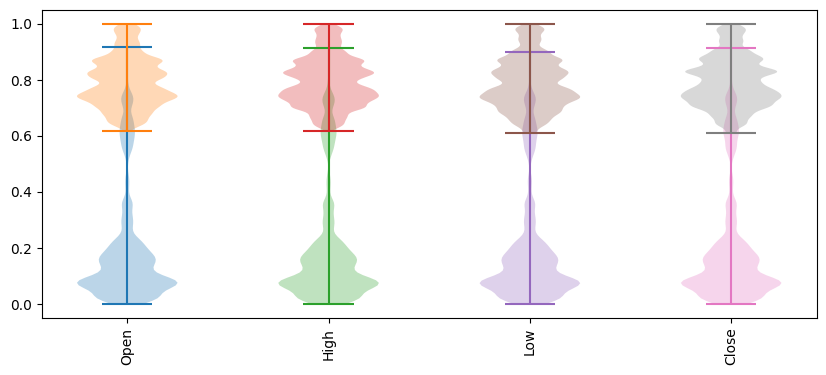

In [36]:
# Gráfica de violín para ver la distribución de los valores en cada covariable
cols=x_train.shape[2]
fig, ax = plt.subplots(figsize=(10,4))
col_name=df1.columns[1:]

for i in range(cols):
    ax.violinplot(dataset=x_train[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_test[:,:,i].flatten(), positions=[i])

# Etiquetas del eje horizontal
ax.set_xticks(list(range(cols)))
ax.set_xticklabels(col_name, rotation=90)
ax.autoscale();

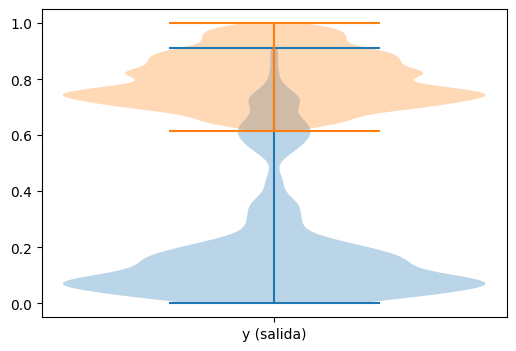

In [37]:
# Gráfica de violín para ver la distribución de los valores de la variable de salida
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_train.flatten())
ax.violinplot(dataset=y_test.flatten())
ax.set_xticks([1])
ax.set_xticklabels(["y (salida)"]);

Se observa que el rango de x e y tanto de entrenamiento y prueba están en el rango específico que planteamos anteriormente. Además, para esta empresa en particular y para casi la mayoría de empresas, se puede ver nuevamente un comportamiento creciente en los últimos años, ya que el gráfico de violín del set de testeo se encuentra en la parte superior de la gráfica.

**CONCLUSIÓN:** Al revisar todos los pasos previos, se evidencia el éxito en la implementación de las funciones para la etapa de Feature Creation. Estas funciones se combinarán en una única función para su aplicación en los conjuntos de datos de cada empresa con el modelo de red LSTM.

In [39]:
# Función unificada
def feature_creation(df, company, input_len, output_len):

  def variable_selection(df, company):
    df2=df.copy()
    df2=df2[df2.id_company==company]
    df2=df2.iloc[:, :5].reset_index(drop=True)
    return df2

  df1=variable_selection(df, company)

  def data_scaling(set_data):
    set_data2=set_data.copy()
    cols=set_data2.columns[1:]
    list_mms=[MinMaxScaler() for c in set_data2.columns]
    for i, c in enumerate(cols):
      set_data2[c]=list_mms[i].fit_transform(set_data2[[c]])
    return set_data2, list_mms[1]

  df2, mms = data_scaling(df1)

  def train_test_split(set_data):
    set_train=set_data[set_data.Date<="2021-12-31"]
    set_test=set_data[set_data.Date>"2021-12-31"]
    return set_train.iloc[:, 1:].values, set_test.iloc[:, 1:].values

  set_train, set_test = train_test_split(df2)

  def find_xy(array, input_len, output_len):
    row, col = array.shape[0], array.shape[1]
    x, y = [], []
    for i in range(row-input_len-output_len+1):
      x.append(array[i:i+input_len])
      y.append(array[i+input_len:i+input_len+output_len, 1].reshape(output_len, 1))
    x=np.array(x)
    y=np.array(y)
    return x, y

  x_train, y_train = find_xy(set_train, input_len, output_len)
  x_test, y_test = find_xy(set_test, input_len, output_len)

  return x_train, y_train, x_test, y_test, mms